In [1]:
#### 10% shapeError and scan 1/m2_q +- 1e-3

In [2]:
from Functions import *
import winsound

# Preliminary

In [3]:
def define_beamline_normal(
    E0, m1_p=185.0, m1_q=-25.6, m2_p=None, m2_q=1e5,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 0.0,
    hkl2 = [2,2,0], alphaAsym2 = 0.0,
    hkl3 = [5,5,5], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=512)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m1_q=m1_q, m2_p=m2_p, m2_q=m2_q)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
                            hkl=hkl3, alphaAsym=alphaAsym3,
                            shapeErrors=shapeErrors,
                            l_crystal=l_crystal,
                            w_crystal=w_crystal)

    all_devices = [im_input] + Telescope_devices + HHLM_devices + HRM_devices
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline

### 1. common simulation parameters

In [4]:
''' Beam parameters '''
N = 1024          # number of sampling points
E0 = 17795        # photon energy [eV]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 650-26
}

##### common simulation parameters
m1_p = 185.0; m1_q = -25.6
m2_q = 1e5
f1 = 10.0; f2 = 10.0            # f1: crystal-mirror distance, f2: mirror focal distance

HHLM_type = '2DCM'              # 2DCM or Zigzag
HHLM_offset=20e-3
pair_distance=200e-3
hkl1 = [1,1,1]; alphaAsym1 = 3.0    # asymmetry angle for the 1st pair of HHLM crystal
hkl2 = [2,2,0]; alphaAsym2 = 7.5    # ````````````````````````2nd pair of HHLM crystal
hkl3 = [5,5,5]; alphaAsym3 = 15.0   # ````````````````````````2nd and 3rd HRM crystal

# list of crystals
crystals = np.array(['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4', 'C1', 'C2']); n_crys = len(crystals)

##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_ev = dir_out + '{}eV/'.format(E0); make_dir(dir_ev)
dir_case = dir_ev + 'm2_q_optimization/'; make_dir(dir_case)

print('\nCWD:',dir_case)

dir_plot = dir_case+'{}_{}_{}/'.format(HHLM_type, hkl1[0]*100+hkl1[1]*10+hkl1[2],
                                      hkl2[0]*100+hkl2[1]*10+hkl2[2]); make_dir(dir_plot)
dir_plot += '{}_{}_deg_{}mm_offset/'.format(alphaAsym1, alphaAsym2, 1e3*HHLM_offset); make_dir(dir_plot)


make path
make path
make path

CWD: output/17795eV/m2_q_optimization/
make path
make path


### 2. calculate crystal dimensions and slit width

In [5]:
%%capture capt

# simulation parameters for the normal condition
slit_width = 1e-1
shapeErrors = [None for i in range(6)]
l_crystal = [1e-1 for i in range(6)]
w_crystal = [5e-3 for i in range(6)]

mono_devices_calc, mono_beamline_calc = define_beamline_normal(E0,
                               m1_p=m1_p, m1_q=m1_q, m2_q=m2_q,
                               HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

b1_calc = beam.Beam(beam_params=beam_params)
b2_calc = mono_beamline_calc.propagate_beamline(b1_calc)

In [6]:
# get crytal properties
beta0s = []; braggs = []; asyms = []
for device in mono_devices_calc:
    if device.name in crystals:
        beta0s.append(device.beta0)
        braggs.append(np.rad2deg(device.bragg))
        asyms.append(np.rad2deg(device.alphaAsym))

# calculate beam FWHM after each crystal
wx1, wy1 = mono_beamline_calc.im_after_HHLM1.beam_analysis(mono_beamline_calc.im_after_HHLM1.get_profile_x(), mono_beamline_calc.im_after_HHLM1.get_profile_y())[2:4]
wx2, wy2 = mono_beamline_calc.im_after_HHLM2.beam_analysis(mono_beamline_calc.im_after_HHLM2.get_profile_x(), mono_beamline_calc.im_after_HHLM2.get_profile_y())[2:4]
wx3, wy3 = mono_beamline_calc.im_after_HHLM3.beam_analysis(mono_beamline_calc.im_after_HHLM3.get_profile_x(), mono_beamline_calc.im_after_HHLM3.get_profile_y())[2:4]
wx4, wy4 = mono_beamline_calc.im_after_HHLM4.beam_analysis(mono_beamline_calc.im_after_HHLM4.get_profile_x(), mono_beamline_calc.im_after_HHLM4.get_profile_y())[2:4]
wx5, wy5 = mono_beamline_calc.im_after_C1.beam_analysis(mono_beamline_calc.im_after_C1.get_profile_x(), mono_beamline_calc.im_after_C1.get_profile_y())[2:4]
wx6, wy6 = mono_beamline_calc.im_after_C2.beam_analysis(mono_beamline_calc.im_after_C2.get_profile_x(), mono_beamline_calc.im_after_C2.get_profile_y())[2:4]
beam_size = np.array([wx1, wx2, wx3, wx4, wx5, wx6])    # FWHM

# crystal lengths (long) and widths (short) [m]
l_crystal = np.divide(beam_size*2, np.sin(beta0s))
w_crystal = np.array([wy1, wy2, wy3, wy4, wy5, wy6])*2

print('bragg angle: {}'.format(np.round(braggs,3)))
print('asymmetry: {}'.format(np.round(asyms,3)))
print('beam size: {} mm'.format(np.round(beam_size*1e3, 3)))
print('footprint: {} mm\n'.format(np.round(l_crystal*1e3/2,  3)))


# calculate slit width
slit_width = calc_slit_width(wx6*2, b2_calc.lambda0, mono_beamline_calc.mir1.q)
print('calculated slit width: {}um'.format(round(slit_width*1e6,2)))

if slit_width < 3e-6: slit_width = 3e-6
print('actual slit width: {}um\n'.format(round(slit_width*1e6,2)))

bragg angle: [ 6.381  6.38  10.455 10.454 33.747 33.747]
asymmetry: [-3.   3.  -7.5  7.5  0.  15. ]
beam size: [3.609 1.306 7.805 1.307 1.306 0.558] mm
footprint: [22.142 22.142 25.322 25.328  2.352  1.738] mm

calculated slit width: 0.58um
actual slit width: 3.0um



### M2_q optimization (perfect case)

In [23]:
%%capture capt
n_loop = 60
inv_m2_q = np.linspace(-1/1e3, 1/1e3, n_loop)
m2_q = 1/inv_m2_q
pulse_duration = np.zeros_like(m2_q)
pulse_tilt = np.zeros_like(m2_q)
spatial_chirp = np.zeros_like(m2_q)
energy_bandwidth = np.zeros_like(m2_q)
throughput = np.zeros_like(m2_q)

# if not os.path.exists(dir_plot+'perfect_{}um_slit.h5'.format(slit_width*1e6)):
for i in range(n_loop):
    mono_devices_p, mono_beamline_p = define_beamline_normal(E0,
                           m1_p=m1_p, m1_q=m1_q, m2_q=m2_q[i],
                           HHLM_type=HHLM_type,
                           HHLM_offset=HHLM_offset,
                           pair_distance=pair_distance,
                           slit_width=slit_width, f1=f1, f2=f2,
                           hkl1=hkl1, alphaAsym1=alphaAsym1,
                           hkl2=hkl2, alphaAsym2=alphaAsym2,
                           hkl3=hkl3, alphaAsym3=alphaAsym3,
                           shapeErrors=[None for i in range(6)],
                           l_crystal=l_crystal,
                           w_crystal=w_crystal)

    screen_names = ['im_input','im_out']

    beam_params['photonEnergy'] = E0
    pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=100e-3, N=100)
    pulse.propagate(beamline=mono_beamline_p,screen_names=screen_names)
    c, pulse_duration[i] = pulse.pulse_duration('im_out')
    pulse_tilt[i] = pulse.pulsefront_tilt('im_out')
    spatial_chirp[i] = pulse.spatial_chirp('im_out')
    energy_bandwidth[i] = pulse.pulse_bandwidth('im_out')
    throughput[i] = pulse.throughput('im_input','im_out')

with h5py.File(dir_plot+'perfect_{}um_slit.h5'.format(slit_width*1e6), 'w') as f:
    f.create_dataset('m2_q', data=m2_q)
    f.create_dataset('pulse_duration', data=pulse_duration)
    f.create_dataset('tilt', data=pulse_tilt)
    f.create_dataset('chirp', data=spatial_chirp)
    f.create_dataset('bandwidth', data=energy_bandwidth)
    f.create_dataset('throughput', data=throughput)
# else:
#     print('perfect case already simulated, skipping to plots')

winsound.Beep(1500, 1000)

output/17795eV/m2_q_optimization/2DCM_111_220/3.0_7.5_deg_20.0mm_offset/
left -1.6949152542372874e-05, right 1.6949152542372874e-05, result 1.8011700979785882e-07
5551946.48813167


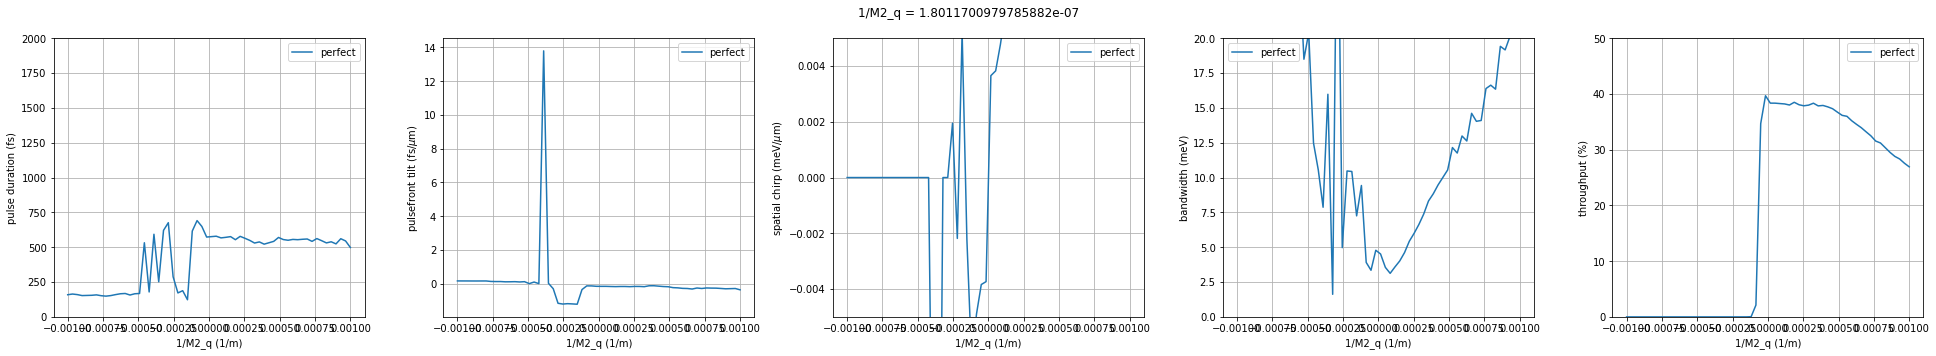

In [29]:
##### m2_p optimization (perfect case)
with h5py.File(dir_plot+'perfect_{}um_slit.h5'.format(slit_width*1e6), 'r') as f:
    m2_q = f['m2_q'][:]
    pulse_duration0 = f['pulse_duration'][:]
    pulse_tilt0 = f['tilt'][:]
    spatial_chirp0 = f['chirp'][:]
    energy_bandwidth0 = f['bandwidth'][:]
    throughput0 = f['throughput'][:]

plot_axis_x0 = 1/m2_q
plot_label_x0 = '1/M2_q (1/m)'
plot_legend0 = 'perfect'
    
print(dir_plot)
try:
    result = find_zero(plot_axis_x0, spatial_chirp0, direction='increase', x_i=-1e-4, x_f=1e-4)
    print(1/result)
except:
    result = plot_axis_x0[energy_bandwidth0.argmin()]

plt.figure(figsize=(27,5))
plt.suptitle('1/M2_q = {}'.format(result))

plt.subplot(1,5,1)
plt.plot(plot_axis_x0, pulse_duration0,label=plot_legend0)
plt.xlabel(plot_label_x0)
plt.ylabel('pulse duration (fs)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim([0, 2e3])

plt.subplot(1,5,2)
plt.plot(plot_axis_x0, pulse_tilt0,label=plot_legend0)
plt.xlabel(plot_label_x0)
plt.ylabel(r'pulsefront tilt (fs/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.subplot(1,5,3)
plt.plot(plot_axis_x0, spatial_chirp0*1000,label=plot_legend0)
plt.xlabel(plot_label_x0)
plt.ylabel(r'spatial chirp (meV/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim([-5e-3, 5e-3])

plt.subplot(1,5,4)
plt.plot(plot_axis_x0, energy_bandwidth0*1000,label=plot_legend0)
plt.xlabel(plot_label_x0)
plt.ylabel('bandwidth (meV)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim([0, 20])

plt.subplot(1,5,5)
plt.plot(plot_axis_x0, throughput0*100,label=plot_legend0)
plt.xlabel(plot_label_x0)
plt.ylabel('throughput (%)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim([0, 50])

plt.savefig(dir_plot+'M2_q_optimization.png')


In [25]:
import winsound
winsound.Beep(1500, 3000)